In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import cycler
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')
import numpy as np
import pandas as pd

import yfinance as yf
from hurst import compute_Hc
import seaborn as sns

import ta
import warnings
from tqdm import tqdm

In [54]:
# Function to do RSI strategy
def rsi(val,neutral,window):
    """

    Input:
    :param val: (type dataframe pandas): Entry values of the stock
    :param neutral:(float) Value of the neutrality, i.e No Action Zone
    :param window: (float) rolling period for RSI calculation

    Output: The function gives the returns of RSI strategy
    :return:
    """
    # Print error is no Adj Close column is not present
    if "Adj Close" not in val.columns:
        ValueError("Error: No Adj Close column is present")

    val['rsi'] = ta.momentum.RSIIndicator(val['Adj Close'], window=window).rsi()

    """Long Buy signal"""
    overbuy = 70
    neutral_buy = 50 + neutral

    # Put nan values for te signal long columns
    val["signal_long"] = np.nan
    val["yesterday_rsi"] = val["rsi"].shift(1)
    # We need to define open long signal (Rsi yes>55 and RSI today>55)
    val.loc[(val["rsi"]> neutral_buy) & (val["yesterday_rsi"] <neutral_buy),"signal_long"] = 1
    # open long signal for false positive (Rsi yes>55 and RSI today<55)
    val.loc[(val["rsi"]< neutral_buy) & (val["yesterday_rsi"] >neutral_buy),"signal_long"] = 0
    # open long signal for overbuy (Rsi yes>70 and RSI today<70)
    val.loc[(val["rsi"]< overbuy) & (val["yesterday_rsi"] >overbuy),"signal_long"] = 0

    """Short Sell signal"""
    oversell = 30
    neutral_sell = 50 - neutral

    # Put the values for the short signal columns
    val['signal_short'] = np.nan
    val["yersteday_rsi"] = val["rsi"].shift(1)
    # We define the Open short signal (RSI yes>45 and RSI today<45)
    val.loc[(val['rsi']<neutral_sell) & (val['yesterday_rsi']>neutral_sell),'signal_short'] = -1

    # We define the Close short signal(Rsi yes<45 and RSI today>45) False signal
    val.loc[(val['rsi']>neutral_sell) & (val['yesterday_rsi']<neutral_sell),'signal_short'] = 0

    # We define the Close short signal (RSI yes<30 and RSI today>30) Oversell
    val.loc[(val['rsi']>oversell) & (val['yesterday_rsi']<oversell),'signal_short'] = 0

    """Compute the returns"""
    # Compute the percentage of the variation of the stock
    val['pct'] = val['Adj Close'].pct_change(1)

    # Calculate the position
    val['Position'] = (val['signal_short'].fillna(method='ffill') + val['signal_long'].fillna(method='ffill'))

    # Compute the returns
    val['return'] = val['pct']*(val['Position'].shift(1))

    return val['return']

In [6]:
data = yf.download('GOOG')

[*********************100%***********************]  1 of 1 completed


In [43]:
rsi(data['2010'],5,14).dropna()

45


C:\Users\ksmur\AppData\Local\Temp/ipykernel_13672/2092380708.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  val,i = rsi(data['2010'],5,14)
C:\Users\ksmur\AppData\Local\Temp/ipykernel_13672/2460290506.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['rsi'] = ta.momentum.RSIIndicator(val['Adj Close'], window=window).rsi()
C:\Users\ksmur\AppData\Local\Temp/ipykernel_13672/2460290506.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Date
2010-03-05    0.017346
2010-03-08   -0.003066
2010-03-09   -0.004071
2010-03-10    0.029026
2010-03-11    0.008136
                ...   
2010-12-27   -0.003062
2010-12-28   -0.005744
2010-12-29    0.003473
2010-12-30   -0.003561
2010-12-31   -0.000000
Name: return, Length: 210, dtype: float64

In [11]:
def beta_function(series):
	sp500 = yf.download('^GSPC')[['Adj Close']].pct_change(1)
	sp500.columns = ['SP500']

	# We concatenate the two dataframe
	value = pd.concat((series, sp500), axis=1)

	# We compute the beta
	beta = np.cov(value[[series.name, "SP500"]].dropna().values,rowvar=False)[0][1] / np.var(value["SP500"].dropna().values)
	return beta

In [12]:
def drawdown_function(series):
	cumulative_sum = series.dropna().cumsum() + 1  # multiplication coefficient
	# compute the max of the cumulative_sum
	# (1,3,1,1,7,1,2,) -> (1,3,3,3,7,7,7)
	running_max = np.maximum.accumulate(cumulative_sum)
	drawdowned = cumulative_sum / running_max - 1
	return drawdowned

In [27]:

def backTest(series):
	# Import the Bechmark
	sp500 = yf.download('^GSPC')['Adj Close'].pct_change(1)
	print(sp500.head(),series.dropna().head())
	sp500.name = 'SP500'

	# We concatenate the two dataframe
	value = pd.concat((series, sp500), axis=1).dropna()

	# compute the drawdown and max drawdown
	drawdown = drawdown_function(series)
	max_drawdown = -np.min(drawdown)

	"""Plot the Graph"""
	fig, (cum, drawed) = plt.subplots(1, 2, figsize=(15, 6))
	fig.suptitle("Backtesting", size=20)

	cum.plot(series.cumsum(), color='#39B3C7')
	cum.plot(value["SP500"].cumsum(), color='#B85A0F')

	cum.legend(["Portfolio", "Benchmark"])
	cum.set_title("Cumulative Returns", size=13)
	cum.set_ylabel("Cumulative Return in %", size=13)

	# Plot the drawdown
	drawed.fill_between(drawdown.index, 0, drawdown, color='#C73954', alpha=0.65)

	drawed.set_title("Drawdown", size=15)
	drawed.set_ylabel("Drawdown in %", size=13)

	# plot the graph
	plt.show()

	"""Compute the statistics"""
	# compute the sortino
	sortino = np.sqrt(252) * series.mean() / series.loc[series < 0].std()

	# compute the beta
	# beta = np.cov(value[["return", "SP500"]].values, rowvar=False)[0][1] / np.var(value["SP500"].values)
	beta = beta_function(series)
	print(series)
	# compute the alpha
	alpha = 252 * series.mean() - beta * series.mean()

	# Print the statistics

	print(f'Sortino: {np.round(sortino, 3)}')
	print(f'Beta: {np.round(beta, 3)}')
	print(f'Alpha: {np.round(alpha, 3)}')
	print(f'MaxDrawdown: {np.round(max_drawdown, 3)}')

In [55]:
rsi(data,10,3).dropna()

Date
2004-08-31   -0.003529
2004-09-01    0.020709
2004-09-02   -0.012569
2004-09-03   -0.000000
2004-09-07    0.000000
                ...   
2022-01-03   -0.002730
2022-01-04   -0.000000
2022-01-05   -0.000000
2022-01-06   -0.000000
2022-01-07   -0.000000
Name: return, Length: 4371, dtype: float64

[*********************100%***********************]  1 of 1 completed
Date
1950-01-03         NaN
1950-01-04    0.011405
1950-01-05    0.004748
1950-01-06    0.002953
1950-01-09    0.005889
Name: Adj Close, dtype: float64 Date
2004-08-31   -0.003529
2004-09-01    0.020709
2004-09-02   -0.012569
2004-09-03   -0.000000
2004-09-07    0.000000
Name: return, dtype: float64


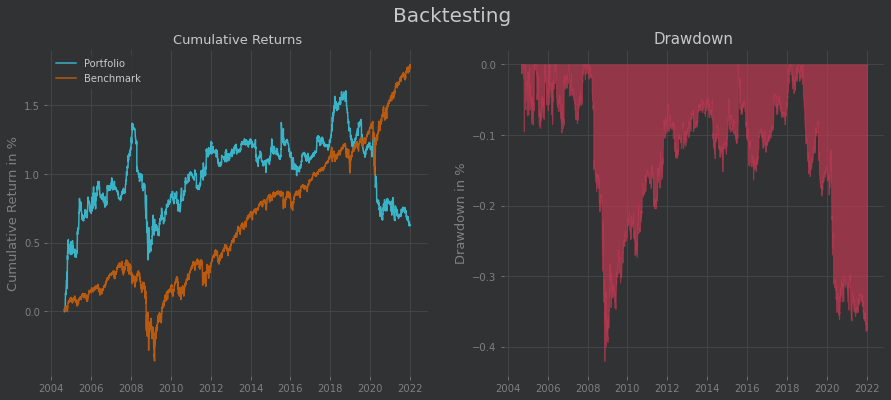

[*********************100%***********************]  1 of 1 completed
Date
2004-08-19        NaN
2004-08-20        NaN
2004-08-23        NaN
2004-08-24        NaN
2004-08-25        NaN
               ...   
2022-01-03   -0.00273
2022-01-04   -0.00000
2022-01-05   -0.00000
2022-01-06   -0.00000
2022-01-07   -0.00000
Name: return, Length: 4379, dtype: float64
Sortino: 0.148
Beta: -0.318
Alpha: 0.036
MaxDrawdown: 0.42


In [56]:
backTest(rsi(data,10,3))